In [3]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

In [4]:
root_dir = "/dss/dsstbyfs02/pn49cu/pn49cu-dss-0006/Sen12Landslides/outputs/exp1/final"
model_names = ["unet_convlstm", "unet3d", "utae", "convgru"] 
dataset_names = ["s1asc", "s1dsc", "s2"]

In [5]:
def load_predictions(pred_file):
    data = torch.load(pred_file, map_location='cpu', )
    return data["preds"], data["masks"]

pred_idx = 0
predictions_dict = {}
for ds in dataset_names:
    predictions_dict[ds] = {}
    for model in model_names:
        pred_file = os.path.join(root_dir, ds, model, "predictions", f"predictions_{pred_idx}.pt")
        if os.path.exists(pred_file):
            preds, masks = load_predictions(pred_file)
            predictions_dict[ds][model] = (preds, masks)
        else:
            print(f"No predictions file found for dataset={ds}, model={model}, pred_idx={pred_idx}")
            predictions_dict[ds][model] = (None, None)

/dss/dsstbyfs02/scratch/0F/di35viw/di35viw/ipykernel_78010/1168703978.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(pred_file, map_location='cpu', )


In [6]:
def visualize_predictions(predictions_dict, model_names, dataset_names, sample_idx=0, fontsize=8):
    # Mapping from prediction keys to printed names
    model_print_names = {
        "convgru": "ConvGRU",
        "unet_convlstm": "U-ConvLSTM",
        "utae": "U-TAE",
        "unet3d": "UNet3D"
    }

    n_rows = len(dataset_names)
    n_cols = len(model_names) + 1  # extra column for ground truth

    # Increase figure size for better readability
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows))

    # Ensure axes is 2D (in case of a single row or column)
    if n_rows == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = axes[:, np.newaxis]

    for i, ds in enumerate(dataset_names):
        for j, model in enumerate(model_names):
            preds, _ = predictions_dict[ds][model]
            ax = axes[i, j]
            if preds is None:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=fontsize)
                ax.axis('off')
            else:
                # Get prediction sample and normalize for display
                pred_sample = preds[sample_idx].cpu().numpy()
                norm_pred = (pred_sample - pred_sample.min()) / (pred_sample.max() - pred_sample.min() + 1e-8)
                ax.imshow(norm_pred, cmap='gray')
                # Set title only for the first row
                if i == 0:
                    ax.set_title(model_print_names.get(model, model), fontsize=fontsize)
                ax.axis('off')
        
        # Last column: ground truth (GT) mask
        ax = axes[i, -1]
        gt_found = False
        for model in model_names:
            _, masks = predictions_dict[ds][model]
            if masks is not None:
                gt_sample = masks[sample_idx].cpu().numpy()
                norm_gt = (gt_sample - gt_sample.min()) / (gt_sample.max() - gt_sample.min() + 1e-8)
                ax.imshow(norm_gt, cmap='gray')
                # Set the title only for the first row
                if i == 0:
                    ax.set_title("Ground Truth", fontsize=fontsize)
                ax.axis('off')
                gt_found = True
                break
        if not gt_found:
            ax.text(0.5, 0.5, 'No GT', ha='center', va='center', fontsize=fontsize)
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(root_dir, f"predictions_comparison_sample{sample_idx}.png"), dpi=300)
    plt.show()

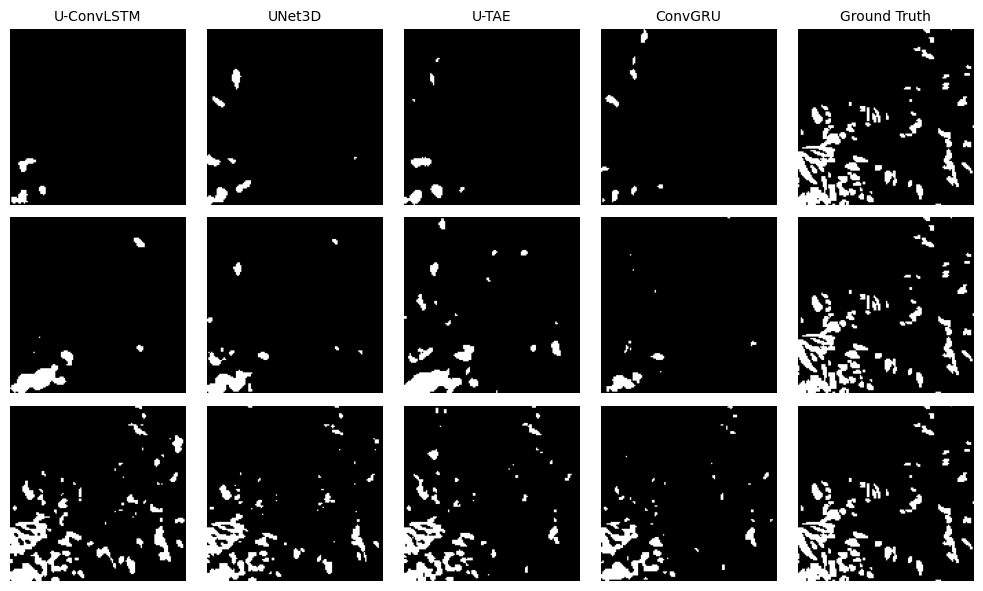

In [8]:
sample_idx = 15
fontsize = 10
visualize_predictions(predictions_dict, model_names, dataset_names, sample_idx=sample_idx, fontsize=fontsize)